In [1]:
from utils.analysis import *
from utils.constants import *
from utils.paths import *
from utils.extremes import *
from utils.get_monthly_data import *
from utils.plotting import *

import pandas as pd
import xarray as xr
import os
import numpy as np
from tqdm import tqdm
import itertools as it
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

from monthly_percity_fit_per_pixel import Norm

luc_list = ['Evergreen forest', 'Deciduous forest', 'Shrub', 'Grass', 'Wetland']
ntree_list = [1000, 5000, 10000, 50000]

In [2]:
""" Check the OOB score
    There are virtually no difference between the various numbers of trees.
"""
for stat in ['Resistance', 'Recovery']:
    collect = pd.DataFrame(np.nan, index = pd.MultiIndex.from_product([['DJF', 'MAM', 'JJA', 'SON'], luc_list, ['daymet', 'topowx', 'yyz']]), columns = ntree_list)
    for season in ['DJF', 'MAM', 'JJA', 'SON']:
        for luc in luc_list:
            for use in ['daymet', 'topowx', 'yyz']:
                setup = Setup(use)
                filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'fit',
                                        f'percity_per_pixel_oob_score_{setup.format_prefix()}_heat_wave_{season}_{luc}_{stat}.csv')
                collect.loc[(season, luc, use), :] = pd.read_csv(filename, index_col = 0).iloc[:, 0]

    fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize = (10, 10))
    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        for j, ntree in enumerate(ntree_list):
            ax = axes[i, j]

            img = collect.loc[season, ntree].unstack()
            cf = ax.imshow(img, vmin = 0., vmax = 0.6, cmap = 'RdYlBu', aspect = 0.5)

            if j == 0:
                ax.set_ylabel(season)
            if i == 0:
                ax.set_title(ntree)

            ax.set_xticks([])
            ax.set_yticks([])

    fig.text(0.5, 1.01, stat, fontsize = 12, ha = 'center')
    cax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    plt.colorbar(cf, cax = cax, orientation = 'horizontal')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_per_pixel_oob_score_summary_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{stat}.png'))
    plt.close(fig)

/tmp/ipykernel_2876861/2349042801.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  img = collect.loc[season, ntree].unstack()
/tmp/ipykernel_2876861/2349042801.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  img = collect.loc[season, ntree].unstack()


In [19]:
""" Validation performance. 
    Collect the brier score, precision, recall, and f1score of all the classifications. 
    Collect the bias, rmse, corr, and std_ratio of all the regressions.
"""
collect = pd.DataFrame(np.nan, 
                       index = pd.MultiIndex.from_product([['precision', 'recall', 'f1score', 'brier'], ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]),
                       columns = pd.MultiIndex.from_product([['Resistance', 'Recovery'], luc_list]))
for stat in ['Resistance', 'Recovery']:
    for luc in luc_list:
        for use in ['daymet', 'topowx', 'yyz']:
            for season in ['DJF', 'MAM', 'JJA', 'SON']:
                setup = Setup(use)
                filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                                        f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Sign.h5')
                with pd.HDFStore(filename, mode = 'r') as h:                
                    # remove the scaling factor used in regression
                    collect.loc[('precision', season, use), (stat, luc)] = h.select('performance').loc['test', 'precision']
                    collect.loc[('recall', season, use), (stat, luc)] = h.select('performance').loc['test', 'recall']
                    collect.loc[('f1score', season, use), (stat, luc)] = h.select('performance').loc['test', 'f1score']
                    collect.loc[('brier', season, use), (stat, luc)] = h.select('performance').loc['test', 'brier']
collect.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                            f'percity_per_pixel_rmse_summary_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_Sign.csv'))


collect = pd.DataFrame(np.nan, 
                       index = pd.MultiIndex.from_product([['bias', 'corr', 'corr_p', 'rmse', 'std_ratio'], ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]),
                       columns = pd.MultiIndex.from_product([['Resistance', 'Recovery'], luc_list]))
for stat in ['Resistance', 'Recovery']:
    for luc in luc_list:
        for use in ['daymet', 'topowx', 'yyz']:
            for season in ['DJF', 'MAM', 'JJA', 'SON']:
                setup = Setup(use)
                filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                                        f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Mag.h5')
                with pd.HDFStore(filename, mode = 'r') as h:                
                    # remove the scaling factor used in regression
                    collect.loc[('bias', season, use), (stat, luc)] = h.select('performance').loc['test', 'bias'] / 100.
                    collect.loc[('corr', season, use), (stat, luc)] = h.select('performance').loc['test', 'corr']
                    collect.loc[('rmse', season, use), (stat, luc)] = h.select('performance').loc['test', 'rmse'] / 100.
                    # forgot to calculate these on the fly
                    collect.loc[('corr_p', season, use), (stat, luc)] = pearsonr(h.select('y_pred_test').values[:, 0], h.select('y_test').values[:, 0])[1]
                    collect.loc[('std_ratio', season, use), (stat, luc)] = np.std(h.select('y_pred_test').values) / np.std(h.select('y_test').values)
collect.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                            f'percity_per_pixel_rmse_summary_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_Mag.csv'))

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing pas

In [3]:
""" Validation performance.
    Check if recreated the urban-rural difference in sign & magnitude of the resilience.
"""
y_test_diff = {}
y_pred_test_diff = {}
y_pred_test_std  = {}
shap_values_diff = {}
for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):
    setup = Setup(use)

    file_prefix = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                               f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000')

    with pd.HDFStore(f'{file_prefix}_Sign.h5', mode = 'r') as hf:
        y_test = hf.select('y_test')[stat].sort_index(axis = 0)
        y_pred_test = hf.select('y_pred_test')[stat].sort_index(axis = 0)
        shap_values = hf.select('shap_values').sort_index(axis = 0)

        y_pred_test_std[(luc, stat, season, use)] = y_pred_test.groupby(['fid', 'start', 'end']).std()

        location = add_urlabel_all(shap_values.index.to_frame(index = False), setup.extent)['location'].values

        y_test_urban_sign = (y_test.loc[location == 'urban'] > 0).astype(float).groupby(['fid', 'start', 'end']).mean()
        y_test_rural_sign = (y_test.loc[location == 'rural'] > 0).astype(float).groupby(['fid', 'start', 'end']).mean()

        # Use a cut-off probability of 0.5

        # !!!!!!!!!!! temporary: saved the wrong label in monthly_percity+_fit_perpixel_analysis.py
        y_pred_test_urban_sign = (y_pred_test.loc[location == 'urban'] < 0.5).astype(float).groupby(['fid', 'start', 'end']).mean()
        y_pred_test_rural_sign = (y_pred_test.loc[location == 'rural'] < 0.5).astype(float).groupby(['fid', 'start', 'end']).mean()

        shap_values_urban_sign = (shap_values.loc[location == 'urban', :] > 0).astype(float).groupby(['fid', 'start', 'end']).mean()
        shap_values_rural_sign = (shap_values.loc[location == 'rural', :] > 0).astype(float).groupby(['fid', 'start', 'end']).mean()

        y_test_diff[('Sign', luc, stat, season, use)] = y_test_urban_sign - y_test_rural_sign
        y_pred_test_diff[('Sign', luc, stat, season, use)] = y_pred_test_urban_sign - y_pred_test_rural_sign
        shap_values_diff[('Sign', luc, stat, season, use)] = (shap_values_urban_sign - shap_values_rural_sign).stack()

    with pd.HDFStore(f'{file_prefix}_Mag.h5', mode = 'r') as hf:
        y_test = hf.select('y_test')[stat].sort_index(axis = 0)
        y_pred_test = hf.select('y_pred_test')[stat].sort_index(axis = 0)
        shap_values = hf.select('shap_values').sort_index(axis = 0)

        y_test_urban_mag = y_test.loc[location == 'urban'].groupby(['fid', 'start', 'end']).median()
        y_test_rural_mag = y_test.loc[location == 'rural'].groupby(['fid', 'start', 'end']).median()
        y_pred_test_urban_mag = y_pred_test.loc[location == 'urban'].groupby(['fid', 'start', 'end']).median()
        y_pred_test_rural_mag = y_pred_test.loc[location == 'rural'].groupby(['fid', 'start', 'end']).median()
        shap_values_urban_mag = shap_values.loc[location == 'urban', :].groupby(['fid', 'start', 'end']).median()
        shap_values_rural_mag = shap_values.loc[location == 'rural', :].groupby(['fid', 'start', 'end']).median()

        y_test_diff[('Mag', luc, stat, season, use)] = y_test_urban_mag - y_test_rural_mag
        y_pred_test_diff[('Mag', luc, stat, season, use)] = y_pred_test_urban_mag - y_pred_test_rural_mag
        shap_values_diff[('Mag', luc, stat, season, use)] = (shap_values_urban_mag - shap_values_rural_mag).stack()

y_test_diff = pd.DataFrame(y_test_diff).stack() # series
y_test_diff.index.names = ['fid', 'start', 'end', 'use']
y_pred_test_diff = pd.DataFrame(y_pred_test_diff).stack()
y_pred_test_diff.index.names = ['fid', 'start', 'end', 'use']
y_pred_test_std  = pd.DataFrame(y_pred_test_std).stack()
y_pred_test_std.index.names = ['fid', 'start', 'end', 'use']
shap_values_diff = pd.DataFrame(shap_values_diff).unstack()
shap_values_diff.columns = shap_values_diff.columns.reorder_levels([0, 1, 2, 3, 5, 4])
shap_values_diff = shap_values_diff.stack()
shap_values_diff.index.names = ['fid', 'start', 'end', 'use']

y_test_diff.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_test_diff.csv'))
y_pred_test_diff.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_pred_test_diff.csv'))
y_pred_test_std.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_pred_test_std.csv'))
shap_values_diff.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_shap_values_diff.csv'))

120it [03:50,  1.92s/it]


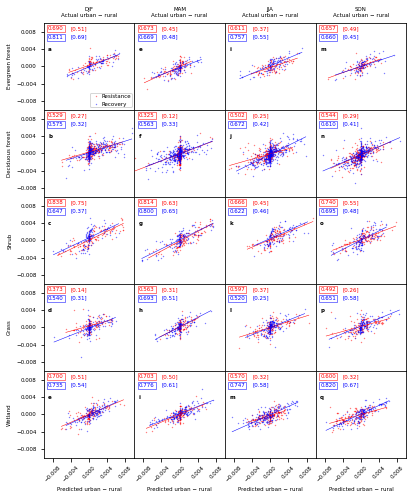

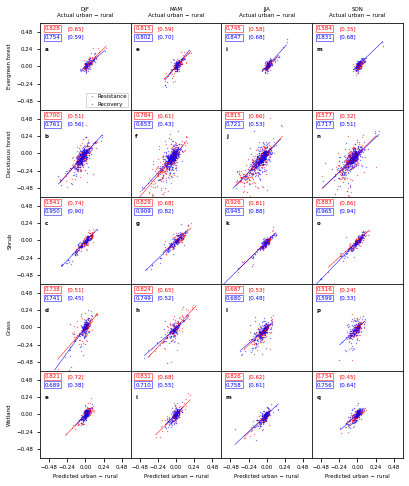

In [8]:
setup = Setup('daymet')

y_test_diff = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                       f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_test_diff.csv'),
                          index_col = [0, 1, 2, 3], header = [0, 1, 2, 3])
y_pred_test_diff = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                            f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_pred_test_diff.csv'),
                               index_col = [0, 1, 2, 3], header = [0, 1, 2, 3])
y_pred_test_std = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary',
                                           f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_y_pred_test_std.csv'),
                              index_col = [0, 1, 2, 3], header = [0, 1, 2, 3])
shap_values_diff = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                            f'percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_shap_values_diff.csv'),
                               index_col = [0, 1, 2, 3], header = [0, 1, 2, 3, 4])

rcParams['font.size'] = 5.5
rcParams['axes.titlesize'] = 5.5
clist = ['r', 'b']
lab = 'abcdefghijklmnopqrstuvwxyz'

for which in ['Sign', 'Mag']:
    if which == 'Mag':
        yrng = 0.6
    else:
        yrng = 0.01

    fig, axes = plt.subplots(len(luc_list), 4, figsize = (6.5, 8), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0., hspace = 0.)
    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        for j, luc in enumerate(luc_list):
            ax = axes[j, i]

            h = [None, None]
            for k, target in enumerate(['Resistance', 'Recovery']):
                x = y_pred_test_diff.loc[:, (which, luc, target, season)].dropna() / 100. # remove the scaling factor used in regression
                y = y_test_diff.loc[:, (which, luc, target, season)].dropna() / 100. # remove the scaling factor used in regression

                h[k] = ax.scatter(x, y, color = clist[k], s = 2, alpha = 0.5, lw = 0.)

                slope = [None] * 3
                intercept = [None] * 3
                r2 = [None] * 3
                rho = [None] * 3
                pval = [None] * 3
                for m, met in enumerate(['daymet', 'topowx', 'yyz']):
                    x_ = x.loc[x.index.get_level_values('use') == met]
                    y_ = y.loc[y.index.get_level_values('use') == met]

                    filt = np.isnan(x_) | np.isnan(y_)
                    x_ = x_[~filt]
                    y_ = y_[~filt]

                    if (len(x_) == 0) | (len(y) == 0):
                        slope[m] = np.nan
                        intercept[m] = np.nan
                        r2[m] = np.nan
                        rho[m] = np.nan
                        pval[m] = np.nan
                        continue

                    res = linregress(x_, y_)
                    slope[m] = res.slope
                    intercept[m] = res.intercept
                    r2[m] = res.rvalue ** 2
                    rho[m], pval[m] = pearsonr(x, y)
                
                slope = np.median(slope)
                intercept = np.median(intercept)
                r2 = np.median(r2)
                rho = np.median(rho)
                pval = np.median(pval)

                #ax.plot([-yrng, yrng], [- yrng * slope + intercept, yrng * slope + intercept], '-', color = clist[k], lw = 0.5, zorder = 3)
                ax.plot([np.min(x), np.max(x)], [np.min(x) * slope + intercept, np.max(x) * slope + intercept], '-', color = clist[k], lw = 0.5, zorder = 3)

                if pval <= 0.05:
                    kwargs = {'bbox': dict(facecolor = 'none', edgecolor = clist[k], pad = 1, lw = 0.5)}
                else:
                    kwargs = {}
                ax.text(0.05, 0.92 - 0.1 * k, f'{rho:.3f}', color = clist[k], transform = ax.transAxes, **kwargs)
                ax.text(0.3, 0.92 - 0.1 * k, f'[{r2:.2f}]', color = clist[k], transform = ax.transAxes)

            if j == 0:
                ax.set_title(f'{season}\nActual urban \u2212 rural')
            if i == 0:
                ax.set_ylabel(luc)
            if j == (len(luc_list)-1):
                ax.set_xlabel('Predicted urban \u2212 rural')

            if (i == 0) & (j == 0):
                ax.legend(h, ['Resistance', 'Recovery'], loc = 'lower right', handletextpad = 0, borderpad = 0.1)

            ax.set_xlim([-yrng, yrng])
            ax.set_xticks([-yrng * 0.8, -yrng * 0.4, 0., yrng * 0.4, yrng * 0.8])
            if which == 'Sign':
                plt.setp(ax.get_xticklabels(), rotation = 45)
            ax.set_ylim([-yrng, yrng])
            if i != 0:
                ax.tick_params('y', length = 0)
            ax.set_yticks([-yrng * 0.8, -yrng * 0.4, 0., yrng * 0.4, yrng * 0.8])
            ax.text(0.05, 0.68, lab[i*4 + j], fontweight = 'bold', transform = ax.transAxes)

    setup = Setup()
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'validation_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.png'),
                dpi = 600., bbox_inches = 'tight', facecolor = 'w')
    plt.close(fig)

In [5]:
""" Save the importance values of the predictors """
for which in ['Sign', 'Mag']:
    importance = pd.DataFrame(np.nan, index = ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event', 
                                               'vpd_in/post_event', 'Evergreen forest', 'Mixed forest',
                                               'Deciduous forest', 'Shrub', 'Grass', 'Crop', 'Wetland',
                                               'impervious_frac', 'event_intensity', 'event_duration', 'elevation',
                                                'optimal_tmax', 'optimal_tmin', 'corr_spi', 'corr_vpd'],
                              columns = pd.MultiIndex.from_product([['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]))

    for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):
        setup = Setup(use)
        filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                                f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_{which}.h5')
        hf = pd.HDFStore(filename, mode = 'r')
        shap_values = hf.select('shap_values').sort_index(axis = 0)
        if which == 'Mag':
            shap_values = shap_values / 100.
        hf.close()
        importance.loc[:, (stat, luc, season, use)] = shap_values.abs().mean(axis = 0).rename({'dtmax_in_event': 'dtmax_in/post_event', 'dtmin_in_event': 'dtmin_in/post_event', 'spi_in_event': 'spi_in/post_event', 
                                                                                               'vpd_in_event': 'vpd_in/post_event', 'dtmax_post_event': 'dtmax_in/post_event', 'dtmin_post_event': 'dtmin_in/post_event', 
                                                                                               'spi_post_event': 'spi_in/post_event', 'vpd_post_event': 'vpd_in/post_event'})
    importance.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                f'importance_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.csv'))
importance

120it [00:04, 26.61it/s]
120it [00:04, 26.17it/s]


Resistance                                          \
                    Evergreen forest                                           
                                 DJF                           MAM             
                              daymet    topowx       yyz    daymet    topowx   
dtmax_in/post_event         0.005313  0.004594  0.005364  0.004981  0.006320   
dtmin_in/post_event         0.006924  0.005023  0.004990  0.009177  0.007169   
spi_in/post_event           0.010760  0.012517  0.008483  0.025493  0.049570   
vpd_in/post_event           0.013227  0.007200  0.007829  0.014446  0.030095   
Evergreen forest            0.018012  0.006888  0.004692  0.003823  0.002693   
Mixed forest                0.001925  0.001102  0.002991  0.001642  0.002178   
Deciduous forest            0.001493  0.001880  0.001778  0.004634  0.001884   
Shrub                       0.001269  0.001661  0.001034  0.001001  0.000950   
Grass                       0.001139  0.001590  0.001401  0.001489  0.003287   
Crop                        0.000442  0.000434  0.000476  0.000858  0.000370   
Wetland                     0.002629  0.001367  0.001769  0.001872  0.002896   
impervious_frac             0.010264  0.010160  0.012869  0.009252  0.004743   
event_intensity             0.024227  0.014463  0.022541  0.010834  0.026757   
event_duration              0.043665  0.030342  0.054543  0.047983  0.034326   
elevation                   0.018857  0.013982  0.027201  0.014472  0.015201   
optimal_tmax                0.002223  0.002078  0.002163  0.002077  0.002285   
optimal_tmin                0.003766  0.003710  0.005329  0.007169  0.006472   
corr_spi                    0.004930  0.005389  0.005206  0.006285  0.008482   
corr_vpd                    0.005916  0.004485  0.007004  0.024125  0.019188   

                                                                       ...  \
                                                                       ...   
                                    JJA                           SON  ...   
                          yyz    daymet    topowx       yyz    daymet  ...   
dtmax_in/post_event  0.006011  0.004557  0.004356  0.011625  0.005424  ...   
dtmin_in/post_event  0.003640  0.005032  0.004507  0.003259  0.005950  ...   
spi_in/post_event    0.007760  0.005663  0.007411  0.006959  0.006892  ...   
vpd_in/post_event    0.024359  0.009745  0.005614  0.009665  0.011733  ...   
Evergreen forest     0.008421  0.008529  0.003653  0.005916  0.005719  ...   
Mixed forest         0.001059  0.000630  0.002220  0.000827  0.001486  ...   
Deciduous forest     0.002101  0.001240  0.001935  0.001874  0.001749  ...   
Shrub                0.000900  0.002674  0.000750  0.002681  0.000865  ...   
Grass                0.001420  0.002479  0.002262  0.001912  0.002108  ...   
Crop                 0.000897  0.000896  0.000907  0.000591  0.000805  ...   
Wetland              0.001808  0.001816  0.002161  0.001738  0.001965  ...   
impervious_frac      0.008394  0.007754  0.008978  0.005353  0.008380  ...   
event_intensity      0.027721  0.017644  0.011987  0.021074  0.016557  ...   
event_duration       0.047229  0.048598  0.047968  0.042803  0.040366  ...   
elevation            0.016336  0.008336  0.012232  0.007665  0.021110  ...   
optimal_tmax         0.002228  0.002249  0.003310  0.002080  0.002914  ...   
optimal_tmin         0.006284  0.003467  0.004186  0.003352  0.004664  ...   
corr_spi             0.004973  0.004835  0.004586  0.005992  0.005163  ...   
corr_vpd             0.010796  0.005252  0.008574  0.005620  0.005802  ...   

                     Recovery                                          \
                      Wetland                                           
                          DJF       MAM                           JJA   
                          yyz    daymet    topowx       yyz    daymet   
dtmax_in/post_event  0.008019  0.008436  0.006175  0.006224  0.007386   
dtmin_in/post_event  0.00

In [7]:
""" Spearman's correlation between the SHAP values of each predictor and its value
"""
for which in ['Sign', 'Mag']:
    dependency = pd.DataFrame(np.nan,
                            index = ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event',
                                    'vpd_in/post_event', 'Evergreen forest', 'Mixed forest',
                                    'Deciduous forest', 'Shrub', 'Grass', 'Crop', 'Wetland',
                                    'impervious_frac', 'event_intensity', 'event_duration', 'elevation',
                                    'optimal_tmax', 'optimal_tmin', 'corr_spi', 'corr_vpd'],
                            columns = pd.MultiIndex.from_product([['rho', 'pvalue'], ['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]))

    for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):
        setup = Setup(use)
        filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                                f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_{which}.h5')

        n = Norm()
        n.load(os.path.join(path_out, 'measures', 'regression_per_pixel', 'fit', 
                            f'percity_per_pixel_norm_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_{which}.csv'))

        hf = pd.HDFStore(filename, mode = 'r')
        if which == 'Sign':
            shap_values = hf.select('shap_values').sort_index(axis = 0)
        else:
            shap_values = hf.select('shap_values').sort_index(axis = 0) / 100.
        X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))
        hf.close()

        for c in X_test.columns:
            rho, pval = spearmanr(X_test[c].values, shap_values[c].values)
            if 'in_event' in c:
                c = c.replace('in_event', 'in/post_event')
            elif 'post_event' in c:
                c = c.replace('post_event', 'in/post_event')
            dependency.loc[c, ('rho', stat, luc, season, use)] = rho
            dependency.loc[c, ('pvalue', stat, luc, season, use)] = pval

        dependency.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                    f'dependency_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.csv'))

120it [00:20,  5.97it/s]
120it [00:20,  5.88it/s]


In [16]:
""" Display the important predictors and their partial dependencies """
setup = Setup()

for which in ['Sign', 'Mag']:

    importance = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                          f'importance_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.csv'),
                            index_col = 0, header = [0, 1, 2, 3])


    # Drop the non-key land cover types
    importance2 = importance.copy()
    importance2.loc['rural land cover', :] = np.full(importance2.shape[1], np.nan)
    for c in importance2.columns:
        importance2.loc['rural land cover', c] = importance2.loc[c[1], c]
    importance = importance2.drop(luc_list + ['Crop', 'Mixed forest'], axis = 0)


    # Order the importance by rank
    importance_rank = importance.mean(axis = 1).sort_values()
    top_predictors = importance_rank.index[::-1]
    importance = importance.loc[top_predictors, :]


    dependency = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                          f'dependency_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.csv'), 
                            index_col = 0, header = [0, 1, 2, 3, 4])
    dependency2 = dependency.copy()
    dependency2.loc['rural land cover', :] = np.full(dependency2.shape[1], np.nan)
    for c in dependency2.columns:
        dependency2.loc['rural land cover', c] = dependency2.loc[c[2], c]
    dependency2 = dependency2.drop(luc_list + ['Crop', 'Mixed forest'], axis = 0)
    dependency = dependency2.loc[top_predictors, :]


    rcParams['font.size'] = 5.5
    rcParams['axes.titlesize'] = 5.5
    lab = 'abcdefghijklmnopqrst'

    fig, axes = plt.subplots(4, len(luc_list), figsize = (6.5, 7.5), sharex = True, sharey = False)
    fig.subplots_adjust(hspace = 0.05)
    for k, var in enumerate([importance, dependency]):
        if k == 0:
            varname = 'Importance value'
            norm = BoundaryNorm([0, 0.001, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, .12], ncolors = 256, clip = False, extend = 'neither')
            cmap = 'Blues'
        else:
            varname = 'Partial dependency'
            norm = BoundaryNorm(np.linspace(-1, 1, 21), ncolors = 256, clip = False, extend = 'neither')
            cmap = cmap_div(thres = 0.1)

        for i, stat in enumerate(['Resistance', 'Recovery']):
            for j, luc in enumerate(luc_list):
                ax = axes[i + k*2, j]

                if k == 0:
                    temp = var.loc[:, (stat, luc)]
                else:
                    temp = var.loc[:, ('rho', stat, luc)]
                    temp_p = var.loc[:, ('pvalue', stat, luc)]

                temp.columns.names = ['season', 'use']
                temp.index.names = ['predictors']
                temp = temp.stack().stack().groupby(['predictors', 'season']).median().unstack()
                temp = temp.loc[top_predictors]

                cf = ax.imshow(temp, norm = norm, cmap = cmap, aspect = 0.6)

                if k == 1:
                    temp_p.columns.names = ['season', 'use']
                    temp_p.index.names = ['predictors']
                    temp_p = temp_p.stack().stack().groupby(['predictors', 'season']).median().unstack()
                    temp_p = temp_p.loc[top_predictors]

                    for a, b in it.product(range(temp_p.shape[0]), range(temp_p.shape[1])):
                        if temp_p.values[a, b] <= 0.05:
                            ax.text(b, a, 'x', fontsize = 6, va = 'center', ha = 'center')

                ax.set_yticks(range(temp.shape[0]))
                if j == 0:
                    ax.set_ylabel(f'{stat}\n{varname}')
                    ax.set_yticklabels(temp.index)
                else:
                    ax.set_yticklabels([])
                ax.set_xticks(range(4))
                if (i == 0) & (k == 0):
                    ax.set_title(luc)
                elif (i == 1) & (k == 1):
                    ax.set_xticklabels(temp_p.columns, rotation = 90)

                ax.text(1.05, 0.95, lab[k * 10 + i * 5  + j], transform = ax.transAxes, fontweight = 'bold')
                ax.tick_params('both', length = 0.)

        if (k == 0):
            cax = fig.add_axes([0.95, 0.53, 0.02, 0.35])
            plt.colorbar(cf, cax, orientation = 'vertical', extend = 'max')
        else:
            cax = fig.add_axes([0.95, 0.13, 0.02, 0.35])
            plt.colorbar(cf, cax, orientation = 'vertical', extend = 'both')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                            f'importance_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{which}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
    plt.close(fig)

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing pas

In [9]:
""" Spearman's correlation between the SHAP values of each predictor and impervious fraction
"""
corr_sign = pd.DataFrame(np.nan,
                    index = ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event',
                             'vpd_in/post_event', 'Evergreen forest', 'Mixed forest',
                             'Deciduous forest', 'Shrub', 'Grass', 'Crop', 'Wetland',
                             'impervious_frac', 'event_intensity', 'event_duration', 'elevation',
                             'optimal_tmax', 'optimal_tmin', 'corr_spi', 'corr_vpd'],
                    columns = pd.MultiIndex.from_product([['diff', 'pvalue'], ['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]))

for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):
    setup = Setup(use)
    filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                            f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Sign.h5')

    n = Norm()
    n.load(os.path.join(path_out, 'measures', 'regression_per_pixel', 'fit', 
                        f'percity_per_pixel_norm_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Sign.csv'))

    hf = pd.HDFStore(filename, mode = 'r')
    shap_values = hf.select('shap_values').sort_index(axis = 0)
    X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))
    hf.close()

    for c in X_test.columns:
        rho, pval = spearmanr(X_test['impervious_frac'].values, shap_values[c].values)
        if 'in_event' in c:
            c = c.replace('in_event', 'in/post_event')
        elif 'post_event' in c:
            c = c.replace('post_event', 'in/post_event')
        corr_sign.loc[c, ('diff', stat, luc, season, use)] = rho
        corr_sign.loc[c, ('pvalue', stat, luc, season, use)] = pval

corr_sign.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                              f'corr_sign_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'))

120it [00:20,  5.76it/s]


In [11]:
""" SHAP value of a predictor * Sign of the predictand
    A SHAP value is contributing to the magnitude of the pixel's value, if it has the same sign as the pixel's value
    Otherwise, it is decreasing the magnitude

    Still Spearman's correlation between this and impervious fraction
"""
corr_mag = pd.DataFrame(np.nan,
                        index = ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event',
                                 'vpd_in/post_event', 'Evergreen forest', 'Mixed forest',
                                 'Deciduous forest', 'Shrub', 'Grass', 'Crop', 'Wetland',
                                 'impervious_frac', 'event_intensity', 'event_duration', 'elevation',
                                 'optimal_tmax', 'optimal_tmin', 'corr_spi', 'corr_vpd'],
                        columns = pd.MultiIndex.from_product([['diff', 'pvalue'], ['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]))

for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):
    setup = Setup(use)
    filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                            f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Mag.h5')

    n = Norm()
    n.load(os.path.join(path_out, 'measures', 'regression_per_pixel', 'fit', 
                        f'percity_per_pixel_norm_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000_Mag.csv'))

    hf = pd.HDFStore(filename, mode = 'r')
    shap_values = hf.select('shap_values').sort_index(axis = 0) / 100.
    y_pred_test = hf.select('y_pred_test').sort_index(axis = 0)[stat]
    for c in shap_values.columns:
        shap_values.loc[:, c] = shap_values.loc[:, c] * np.sign(y_pred_test)
    X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))
    hf.close()

    for c in X_test.columns:
        rho, pval = spearmanr(X_test['impervious_frac'].values, shap_values[c].values)
        if 'in_event' in c:
            c = c.replace('in_event', 'in/post_event')
        elif 'post_event' in c:
            c = c.replace('post_event', 'in/post_event')
        corr_mag.loc[c, ('diff', stat, luc, season, use)] = rho
        corr_mag.loc[c, ('pvalue', stat, luc, season, use)] = pval

corr_mag.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                             f'corr_mag_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'))

120it [00:27,  4.29it/s]


In [12]:
""" Plot 
    (1) percentage positive contributions in the urban minus percentage positive contributions in the rural
    (2) average contribution to the magnitude in the urban minus contribution to the magnitude in the rural
"""
setup = Setup()

# Drop the non-key land cover types
corr_sign = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                   f'corr_sign_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'),
                       index_col = 0, header = [0, 1, 2, 3, 4])
corr_sign.loc['rural land cover', :] = np.full(corr_sign.shape[1], np.nan)
for c in corr_sign.columns:
    corr_sign.loc['rural land cover', c] = corr_sign.loc[c[2], c]
corr_sign = corr_sign.drop(luc_list + ['Crop', 'Mixed forest'], axis = 0)

corr_mag = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                    f'corr_mag_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'),
                           index_col = 0, header = [0, 1, 2, 3, 4])
corr_mag.loc['rural land cover', :] = np.full(corr_mag.shape[1], np.nan)
for c in corr_mag.columns:
    corr_mag.loc['rural land cover', c] = corr_mag.loc[c[2], c]
corr_mag = corr_mag.drop(luc_list + ['Crop', 'Mixed forest'], axis = 0)


rcParams['font.size'] = 5.5
rcParams['axes.titlesize'] = 5.5
lab = 'abcdefghijklmnopqrst'


fig, axes = plt.subplots(4, len(luc_list), figsize = (6.5, 7.5), sharex = True, sharey = False)
fig.subplots_adjust(hspace = 0.05)
for k, var in enumerate([corr_sign, corr_mag]):
    if k == 0:
        varname = 'Contribution to sign'
        # norm_bounds = [-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.025, -0.01, -0.001, 0, 0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
        norm_bounds = np.arange(-.5, .51, 0.05)
    else:
        varname = 'Contribution to magnitude'
        # norm_bounds = [-0.03, -0.025, -0.02, -0.015, -0.01, -0.005, -0.0025, -0.001, -0.0001, 0, 0.0001, 0.001, 0.0025, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
        norm_bounds = np.arange(-.3, .31, 0.03)

    # Order the magnitude of the urban-rural difference
    ranks = pd.DataFrame(np.nan, index = var['diff'].index, columns = var['diff'].columns)
    for i in range(ranks.shape[1]):
        vars = var['diff'].iloc[:, i].abs().fillna(-9999999.) # make the rank lowest
        vars = pd.Series(range(1, 1 + len(vars)), index = vars.sort_values()[::-1].index) # descending
        ranks.loc[vars.index, var['diff'].columns[i]] = vars
    ranks = ranks.stack().stack().stack().stack()
    ranks.index.names = ['predictors', 'use', 'season', 'luc', 'stat']
    ranks = ranks.groupby(['predictors', 'season', 'luc', 'stat']).median().to_frame('rank').reset_index()
    ranks_median = ranks.groupby('predictors').mean()['rank'].sort_values()
    top_predictors = ranks_median.index

    for i, stat in enumerate(['Resistance', 'Recovery']):
        for j, luc in enumerate(luc_list):
        # for j, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
            ax = axes[i + k*2, j]

            temp = var.loc[top_predictors, ('diff', stat, luc)]
            temp.columns.names = ['season', 'use']
            temp.index.names = ['predictors']
            temp = temp.stack().stack().groupby(['predictors', 'season']).median().unstack()
            temp = temp.loc[top_predictors, ['DJF', 'MAM', 'JJA', 'SON']]

            cf = ax.imshow(temp, norm = BoundaryNorm(norm_bounds, ncolors = 256, clip = False, extend = 'neither'),
                           cmap = cmap_div(thres = 0.1), aspect = 0.6)

            temp_p = var.loc[top_predictors, ('pvalue', stat, luc)]
            temp_p.columns.names = ['season', 'use']
            temp_p.index.names = ['predictors']
            temp_p = temp_p.stack().stack().groupby(['predictors', 'season']).median().unstack()
            temp_p = temp_p.loc[top_predictors, ['DJF', 'MAM', 'JJA', 'SON']]

            for a, b in it.product(range(temp_p.shape[0]), range(temp_p.shape[1])):
                if temp_p.values[a, b] <= 0.05:
                    ax.text(b, a, 'x', fontsize = 6, va = 'center', ha = 'center')

            ax.set_yticks(range(temp.shape[0]))
            if j == 0:
                ax.set_ylabel(f'{stat}\n{varname}')
                ax.set_yticklabels(temp.index)
            else:
                ax.set_yticklabels([])
            ax.set_xticks(range(4))
            if (i == 0) & (k == 0):
                ax.set_title(luc)
            elif (i == 1) & (k == 1):
                ax.set_xticklabels(temp_p.columns, rotation = 90)

            ax.text(1.05, 0.95, lab[k * 10 + i * 5  + j], transform = ax.transAxes, fontweight = 'bold')
            ax.tick_params('both', length = 0.)
    if (k == 0):
        cax = fig.add_axes([0.95, 0.53, 0.02, 0.35])
        plt.colorbar(cf, cax, orientation = 'vertical', extend = 'both')
    else:
        cax = fig.add_axes([0.95, 0.13, 0.02, 0.35])
        plt.colorbar(cf, cax, orientation = 'vertical', extend = 'both')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                         f'corr_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)

indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing past lexsort depth may impact performance.
indexing pas

In [13]:
""" Interaction between the intensity / duration of the heat wave with impervious area - rural land cover gradient
"""
xvar = 'intensity'
yvar = 'dtmax_in/post_event'

if xvar == 'intensity':
    xdir_bins = np.arange(0, 5.1, 1)
    xdir_bins_str = [f'{i:.0f}' for i in xdir_bins]
elif xvar == 'intensity_duration':
    xdir_bins = np.arange(0, 18.1, 2.)
    xdir_bins_str = [f'{i:.0f}' for i in xdir_bins]
xdir_bin_edges = np.vstack([np.convolve(np.insert(xdir_bins, 0, -np.inf), [0.5, 0.5], 'valid'),
                            np.convolve(np.append(xdir_bins, np.inf), [0.5, 0.5], 'valid')])

if yvar == 'land_cover':
    # ydir_bins = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    ydir_bins = np.array([-90, -70, -50, -30, -10, -5, 5, 10, 30, 50, 70, 90])
    ydir_bins_str = [str(i) for i in ydir_bins]
elif yvar == 'dtmax_in/post_event':
    ydir_bins = np.arange(-1, 5.1, 0.5) # dtmax_in/post_event
    ydir_bins_str = [f'{i:.1f}' for i in ydir_bins]
ydir_bin_edges = np.vstack([np.convolve(np.insert(ydir_bins.astype('float'), 0, -np.inf), [0.5, 0.5], 'valid'),
                            np.convolve(np.append(ydir_bins.astype('float'), np.inf), [0.5, 0.5], 'valid')])
 

effect = pd.DataFrame(np.nan, index = pd.MultiIndex.from_product([xdir_bins_str, ydir_bins_str]),
                      columns = pd.MultiIndex.from_product([['Sign', 'Magnitude'], ['diff', 'pvalue'], ['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']]))
for stat, luc, season, use in tqdm(it.product(['Resistance', 'Recovery'], luc_list, ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz'])):

    setup = Setup(use)
    filename = os.path.join(path_out, 'measures', 'regression_per_pixel', 'shap', 
                            f'percity_per_pixel_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000.h5')

    n = Norm()
    n.load(os.path.join(path_out, 'measures', 'regression_per_pixel', 'fit', 
                        f'percity_per_pixel_norm_{setup.extent}_{use}_MOD09Q1G_EVI_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_heat_wave_{season}_{luc}_{stat}_1000.csv'))

    hf = pd.HDFStore(filename, mode = 'r')
    # shap_values = hf.select('shap_values').sort_index(axis = 0)[['impervious_frac', luc]].sum(axis = 1) / 100.
    shap_values = hf.select('shap_values').sort_index(axis = 0)[['event_intensity', 'event_duration']].sum(axis = 1) / 100.
    # X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))[['event_intensity', 'event_duration', 'impervious_frac', luc]]
    if stat == 'Resistance':
        X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))[['event_intensity', 'event_duration', 'dtmax_in_event', 'dtmin_in_event']]
    else:
        X_test = n.reverse(hf.select('X_test_norm').sort_index(axis = 0))[['event_intensity', 'event_duration', 'dtmax_post_event', 'dtmin_post_event']]
    y_pred_test = hf.select('y_pred_test').sort_index(axis = 0)
    hf.close()

    if xvar == 'intensity':
        xdir = X_test.loc[:, 'event_intensity']
    elif xvar == 'intensity_duration':
        xdir = (X_test.loc[:, 'event_intensity'] * X_test.loc[:, 'event_duration'])
    if yvar == 'land_cover':
        # ydir = X_test.loc[:, 'event_duration']
        ydir = X_test.loc[:, 'impervious_frac'] * 100. - X_test.loc[:, luc] * 100 # convert to percentage
    elif yvar == 'dtmax_in/post_event':
        if stat == 'Resistance':
            ydir = X_test['dtmax_in_event']
        else:
            ydir = X_test['dtmax_post_event']
    is_positive = shap_values > 0.
    mag_contrib = shap_values * np.sign(y_pred_test.loc[:, stat])
    location = add_urlabel_all(shap_values.to_frame(), setup.extent)['location']

    # del shap_values, X_test, y_pred_test

    for i, j in it.product(range(len(xdir_bins)), range(len(ydir_bins))):
        filt = (xdir >= xdir_bin_edges[0, i]) & (xdir <= xdir_bin_edges[1, i]) & \
               (ydir >= ydir_bin_edges[0, j]) & (ydir <= ydir_bin_edges[1, j])

        if sum(filt) > 10:
            pct_pos = is_positive.loc[filt].mean()
            _, pval_in_sign = wilcoxon(shap_values.loc[filt].values)
            mag = mag_contrib.loc[filt].mean()

            effect.loc[(xdir_bins_str[i], ydir_bins_str[j]), ('Sign', 'diff', stat, luc, season, use)] = pct_pos
            effect.loc[(xdir_bins_str[i], ydir_bins_str[j]), ('Sign', 'pvalue', stat, luc, season, use)] = pval_in_sign
            effect.loc[(xdir_bins_str[i], ydir_bins_str[j]), ('Magnitude', 'diff', stat, luc, season, use)] = mag
            effect.loc[(xdir_bins_str[i], ydir_bins_str[j]), ('Magnitude', 'pvalue', stat, luc, season, use)] = np.nan
effect.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary',
                           f'interaction_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'))

120it [04:25,  2.21s/it]


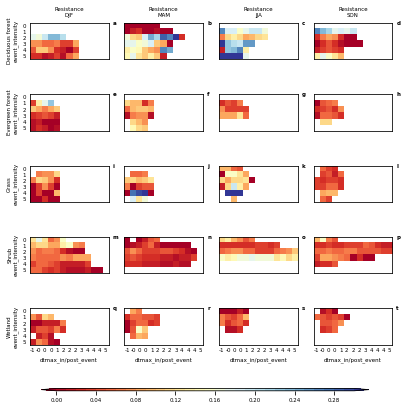

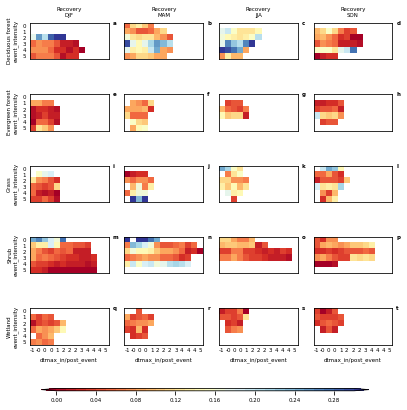

In [6]:
setup = Setup('daymet')
rcParams['font.size'] = 5.5
rcParams['axes.titlesize'] = 5.5
lab = 'abcdefghijklmnopqrst'

varname = 'Magnitude' # Focus only on this one


effect = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                  f'interaction_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}.csv'), 
                     index_col = [0, 1], header = [0, 1, 2, 3, 4, 5])
effect = effect.groupby(level = [0, 1, 2, 3, 4], axis = 1).median() # median of the three meteorological data sets
effect = effect.loc[:, (varname, 'diff')]


if varname == 'Sign':
    varname_long = 'Percent positive values'
    norm = BoundaryNorm(np.array([0, 0.001, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]), ncolors = 256)
    cmap = 'Blues'
else:
    varname_long = 'Contribution to magnitude'
    norm = BoundaryNorm(np.arange(0, 0.31, 0.01), ncolors = 256, extend = 'both')
    cmap = 'RdYlBu' # cmap_div(thres = 0.1)


for stat in ['Resistance', 'Recovery']:
    fig, axes = plt.subplots(len(sorted(luc_list)), 4, figsize = (6.5, 6.5), sharex = True, sharey = False)
    fig.subplots_adjust(hspace = 0.05)

    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        for j, luc in enumerate(sorted(luc_list)):
            ax = axes[j, i]

            temp = effect.loc[:, (stat, luc, season)].unstack()
            cf = ax.imshow(temp, norm = norm, cmap = cmap)

            ax.set_yticks(range(temp.shape[0]))
            ax.set_xticks(range(temp.shape[1]))

            if j == 0:
                ax.set_title(f'{stat}\n{season}')
            elif j == (len(sorted(luc_list))-1):
                ax.set_xticklabels([f'{t:.0f}' for t in temp.columns])
                # ax.set_xlabel(u'impervious frac \u2212\nrural land cover frac (%)')
                ax.set_xlabel('dtmax_in/post_event')

            if i == 0:
                # ax.set_ylabel(f'{luc}\nIntensity' + r'$\times$' + '\nDuration ($^o$C months)')
                ax.set_ylabel(f'{luc}\nevent_intensity')
                ax.set_yticklabels(temp.index)
            else:
                ax.set_yticklabels([])

            """
            if j == 0:
                ax.set_title(f'{stat} {season}')
            elif j == (len(luc_list)-1):
                ax.set_xticklabels([f'{t:.0f}' for t in temp_p.columns])
                ax.set_xlabel(f'Duration (months)')
            if i == 0:
                ax.set_ylabel(f'{luc}\nIntensity ($^o$C)')
                ax.set_yticklabels(temp.index)
            else:
                ax.set_yticklabels([])
            """

            ax.text(1.05, 0.95, lab[i  + j * 4], transform = ax.transAxes, fontweight = 'bold')
            ax.tick_params('both', length = 0.)

    """
    if (k == 0):
        #cax = fig.add_axes([0.95, 0.53, 0.02, 0.35])
        #plt.colorbar(cf, cax, orientation = 'vertical', extend = 'both')
        cax = fig.add_axes([0.15, 0.06, 0.35, 0.005])
        plt.colorbar(cf, cax = cax, orientation = 'horizontal', extend = 'both')
    else:
        #cax = fig.add_axes([0.95, 0.13, 0.02, 0.35])
        #plt.colorbar(cf, cax, orientation = 'vertical', extend = 'both')
        cax = fig.add_axes([0.55, 0.06, 0.35, 0.005])
        plt.colorbar(cf, cax = cax, orientation = 'horizontal', extend = 'both')
    """
    cax = fig.add_axes([0.15, 0.06, 0.7, 0.005])
    plt.colorbar(cf, cax = cax, orientation = 'horizontal', extend = 'both')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary',
                            f'interaction_percity_per_pixel_{setup.extent}_{setup.name}_{setup.heat_wave_thres}_{setup.hot_and_dry_thres}_{stat}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
    # plt.close(fig)